In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
np.random.seed(1234)
random.seed(1234)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
!pwd

/content


In [10]:
train_df=pd.read_csv('/content/drive/MyDrive/titanic_com/data/train.csv')
test_df=pd.read_csv('/content/drive/MyDrive/titanic_com/data/test.csv')
submission=pd.read_csv('/content/drive/MyDrive/titanic_com/data/gender_submission.csv')

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
embarked_df=train_df[['Embarked','Survived','PassengerId']].dropna().groupby(['Embarked','Survived']).count().unstack()
embarked_df

PassengerId     
Survived           0    1
Embarked                 
C                 75   93
Q                 47   30
S                427  217

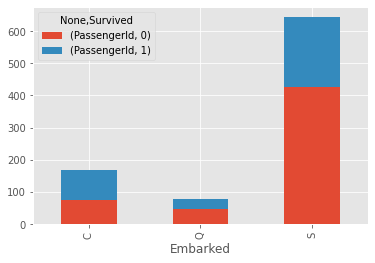

In [13]:
embarked_df.plot.bar(stacked=True)

In [14]:
embarked_df['Survived_rate']=embarked_df.iloc[:,0]/(embarked_df.iloc[:,0]+embarked_df.iloc[:,1])

In [15]:
embarked_df

PassengerId      Survived_rate
Survived           0    1              
Embarked                               
C                 75   93      0.446429
Q                 47   30      0.610390
S                427  217      0.663043

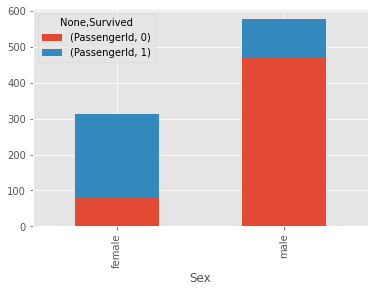

In [16]:
sex_df=train_df[['Sex','Survived','PassengerId']].dropna().groupby(['Sex','Survived']).count().unstack()
sex_df.plot.bar(stacked=True)

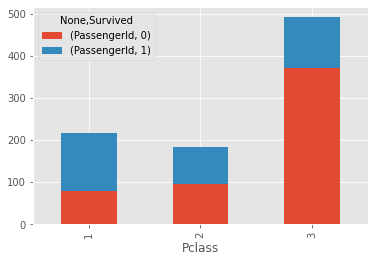

In [17]:
ticket_df=train_df[['Pclass','Survived','PassengerId']].dropna().groupby(['Pclass','Survived']).count().unstack()
ticket_df.plot.bar(stacked=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


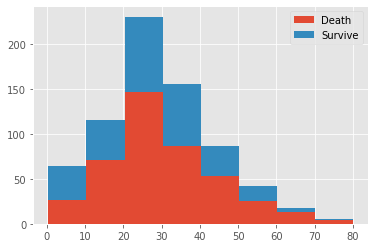

In [18]:
plt.hist((train_df[train_df["Survived"]==0]['Age'].values,train_df[train_df["Survived"]==1]['Age'].values),histtype="barstacked",bins=8,label=("Death","Survive"))
plt.legend()

In [19]:
train_df_corr=pd.get_dummies(train_df,columns=['Sex'],drop_first=True)
train_df_corr=pd.get_dummies(train_df_corr,columns=['Embarked'])

In [20]:
train_corr=train_df_corr.corr()
train_corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,0.042939,-0.001205,-0.033606,0.022148
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.543351,0.168240,0.003650,-0.155660
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.131900,-0.243292,0.221009,0.081720
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.093254,0.036261,-0.022405,-0.032523
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.114631,-0.059528,-0.026354,0.070941
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.245489,-0.011069,-0.081228,0.063036
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182333,0.269335,-0.117216,-0.166603
Sex_male,0.042939,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,1.000000,-0.082853,-0.074115,0.125722
Embarked_C,-0.001205,0.168240,-0.243292,0.036261,-0.059528,-0.011069,0.269335,-0.082853,1.000000,-0.148258,-0.778359
Embarked_Q,-0.033606,0.003650,0.221009,-0.022405,-0.026354,-0.081228,-0.117216,-0.074115,-0.148258,1.000000,-0.496624


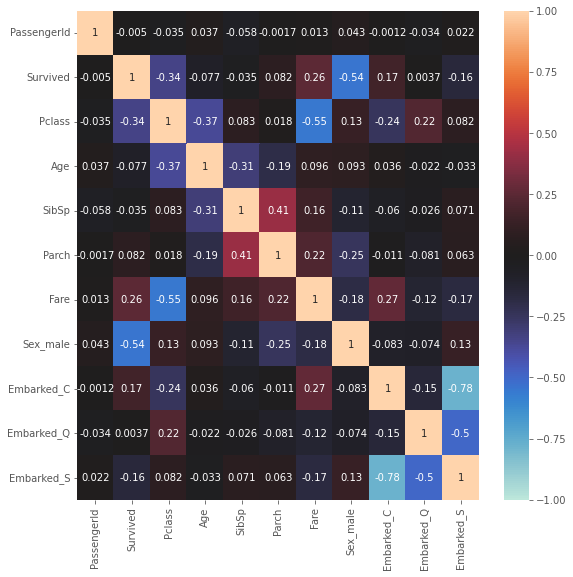

In [21]:
plt.figure(figsize=(9,9))
sns.heatmap(train_corr,vmax=1,vmin=-1,center=0,annot=True)

In [22]:
all_df=pd.concat([train_df,test_df],sort=False).reset_index(drop=True)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [23]:
all_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [24]:
Fare_mean=all_df[['Pclass','Fare']].groupby('Pclass').mean().reset_index()

In [25]:
Fare_mean.columns=['Pclass','Fare_mean']
Fare_mean

,Pclass,Fare_mean
0,1,87.508992
1,2,21.179196
2,3,13.302889


In [26]:
all_df=pd.merge(all_df,Fare_mean,on='Pclass',how='left')
all_df.loc[(all_df['Fare'].isnull()),'Fare']=all_df['Fare_mean']
all_df=all_df.drop('Fare_mean',axis=1)

In [27]:
name_df=all_df['Name'].str.split('[,.]',2,expand=True)
name_df.columns=['familly_name','honorific','name']

In [28]:
name_df['familly_name']=name_df['familly_name'].str.strip()
name_df['honorific']=name_df['honorific'].str.strip()
name_df['name']=name_df['name'].str.strip()

In [29]:
name_df['honorific'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Major             2
Ms                2
Jonkheer          1
Capt              1
Mme               1
Dona              1
the Countess      1
Don               1
Lady              1
Sir               1
Name: honorific, dtype: int64

In [30]:
all_df=pd.concat([all_df,name_df],axis=1)

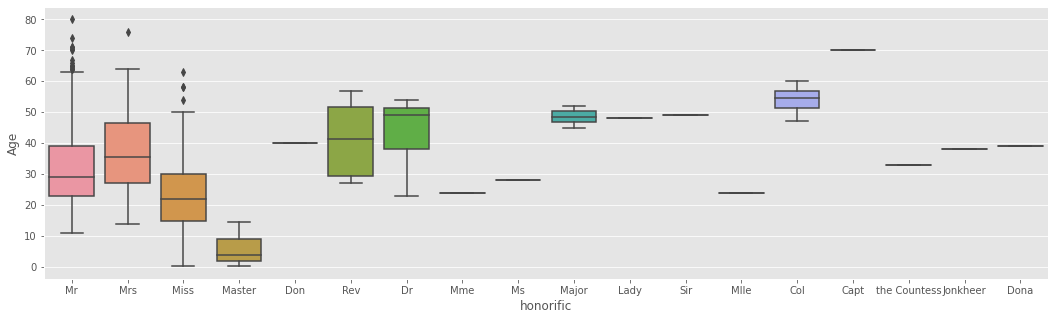

In [31]:
plt.figure(figsize=(18,5))
sns.boxplot(x="honorific",y='Age',data=all_df)

In [32]:
all_df[['Age','honorific']].groupby('honorific').mean()

,Age
honorific,
Capt,70.000000
Col,54.000000
Don,40.000000
Dona,39.000000
Dr,43.571429
Jonkheer,38.000000
Lady,48.000000
Major,48.500000
Master,5.482642


In [33]:
train_df=pd.concat([train_df,name_df[0:len(train_df)].reset_index(drop=True)],axis=1)
test_df=pd.concat([test_df,name_df[len(train_df):].reset_index(drop=True)],axis=1)

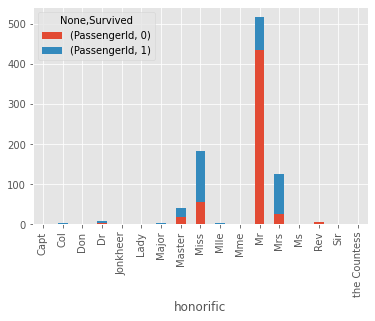

In [34]:
honorific_df=train_df[['honorific','Survived','PassengerId']].dropna().groupby(['honorific','Survived']).count().unstack()
honorific_df.plot.bar(stacked=True)

In [35]:
honorific_age_mean=all_df[['honorific','Age']].groupby('honorific').mean().reset_index()
honorific_age_mean.columns=['honorific','honorific_Age']

In [36]:
all_df=pd.merge(all_df,honorific_age_mean,on='honorific',how='left')
all_df.loc[(all_df['Age'].isnull()),'Age']=all_df['honorific_Age']
all_df=all_df.drop(['honorific_Age'],axis=1)

In [37]:
all_df['familly_num']=all_df['Parch']+all_df['SibSp']
all_df['familly_num'].value_counts()

0     790
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
Name: familly_num, dtype: int64

In [38]:
all_df.loc[all_df['familly_num']==0,'alone']=1
all_df['alone'].fillna(0,inplace=True)

In [39]:
all_df=all_df.drop(['PassengerId','Name','familly_name','name','Ticket','Cabin'],axis=1)

In [40]:
categories=all_df.columns[all_df.dtypes=='object']
print(categories)

Index(['Sex', 'Embarked', 'honorific'], dtype='object')


In [41]:
all_df.loc[~((all_df['honorific']=='Mr')|(all_df['honorific']=='Miss')|(all_df['honorific']=='Mrs')|(all_df['honorific']=='Master')),'honorific']='other'

In [42]:
all_df.honorific.value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
other      34
Name: honorific, dtype: int64

In [43]:
all_df['Embarked'].fillna('missing',inplace=True)

In [44]:
le=LabelEncoder()
le=le.fit(all_df['Embarked'])
all_df['Embarked']=le.transform(all_df['Embarked'])

In [45]:
e=LabelEncoder()
le=le.fit(all_df['Sex'])
all_df['Sex']=le.transform(all_df['Sex'])

In [46]:
e=LabelEncoder()
le=le.fit(all_df['honorific'])
all_df['honorific']=le.transform(all_df['honorific'])

In [47]:
train_X=all_df[~all_df['Survived'].isnull()].drop('Survived',axis=1).reset_index(drop=True)
train_Y=train_df['Survived']

text_X=all_df[all_df['Survived'].isnull()].drop('Survived',axis=1).reset_index(drop=True)

In [48]:
X_train,X_vaild,y_train,y_vaild=train_test_split(train_X,train_Y,test_size=0.2)

In [49]:
categories=['Embarked','Pclass','Sex','honorific','alone']

In [50]:
lgb_train=lgb.Dataset(X_train,y_train,categorical_feature=categories)
lgb_eval=lgb.Dataset(X_vaild,y_vaild,categorical_feature=categories,reference=lgb_train)

In [51]:
lgbm_params={
    "objective":"binary",
    "random_seed":1234
}

In [52]:
model_lgb=lgb.train(lgbm_params,lgb_train,valid_sets=lgb_eval,num_boost_round=100,early_stopping_rounds=20,verbose_eval=10)

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_logloss: 0.465597
[20]	valid_0's binary_logloss: 0.42253
[30]	valid_0's binary_logloss: 0.424173
[40]	valid_0's binary_logloss: 0.438413
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.417458


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [53]:
model_lgb.feature_importance()

array([ 32,  18, 203,  14,   9, 256,  26,   5,  19,   1])

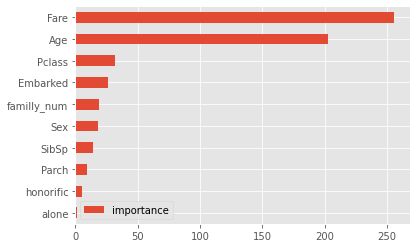

In [54]:
importance=pd.DataFrame(model_lgb.feature_importance(),index=X_train.columns,columns=['importance']).sort_values(by='importance',ascending=True)
importance.plot.barh()

In [55]:
y_pred=model_lgb.predict(X_vaild,num_iteration=model_lgb.best_iteration)

In [56]:
accuracy_score(y_vaild,np.round(y_pred))

0.8435754189944135

In [57]:
lgbm_params={'objective':'binary',
             'max_bin':331,
             'num_levels':20,
             'min_data_in_leaf':57,
             'andom_seed':1234}

In [58]:
lgb_train=lgb.Dataset(X_train,y_train,categorical_feature=categories)
lgb_eval=lgb.Dataset(X_vaild,y_vaild,categorical_feature=categories,reference=lgb_train)

In [59]:
model_lgb=lgb.train(lgbm_params,
                    lgb_train,
                    valid_sets=lgb_eval,
                    num_boost_round=100,
                    early_stopping_rounds=20,                    verbose_eval=10)

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_logloss: 0.470659
[20]	valid_0's binary_logloss: 0.425654
[30]	valid_0's binary_logloss: 0.413748
[40]	valid_0's binary_logloss: 0.410545
[50]	valid_0's binary_logloss: 0.412232
[60]	valid_0's binary_logloss: 0.407988
[70]	valid_0's binary_logloss: 0.407494
[80]	valid_0's binary_logloss: 0.410995
[90]	valid_0's binary_logloss: 0.413203
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.406565


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [60]:
y_pred=model_lgb.predict(X_vaild,num_iteration=model_lgb.best_iteration)

In [61]:
accuracy_score(y_vaild,np.round(y_pred))

0.8491620111731844

In [62]:
folds=3
kf=KFold(n_splits=folds)

In [63]:
models=[]
for train_index,val_index in kf.split(train_X):
  X_train=train_X.iloc[train_index]
  X_vaild=train_X.iloc[val_index]
  y_train=train_Y.iloc[train_index]
  y_vaild=train_Y.iloc[val_index]

  lgb_train=lgb.Dataset(X_train,y_train,categorical_feature=categories)
  lgb_eval=lgb.Dataset(X_vaild,y_vaild,categorical_feature=categories,reference=lgb_train)
  model_lgb=lgb.train(lgbm_params,lgb_train,valid_sets=lgb_eval,num_boost_round=100,early_stopping_rounds=20,verbose_eval=10)
  y_pred=model_lgb.predict(X_vaild,num_iteration=model_lgb.best_iteration)
  print(accuracy_score(y_vaild,np.round(y_pred)))
  models.append(model_lgb)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_logloss: 0.503031
[20]	valid_0's binary_logloss: 0.465863
[30]	valid_0's binary_logloss: 0.454056
[40]	valid_0's binary_logloss: 0.451228
[50]	valid_0's binary_logloss: 0.44724
[60]	valid_0's binary_logloss: 0.447342
[70]	valid_0's binary_logloss: 0.450126
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.445648
0.8249158249158249
Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_logloss: 0.482264
[20]	valid_0's binary_logloss: 0.440853
[30]	valid_0's binary_logloss: 0.435016
[40]	valid_0's binary_logloss: 0.433286
[50]	valid_0's binary_logloss: 0.432128
[60]	valid_0's binary_logloss: 0.430387
[70]	valid_0's binary_logloss: 0.431241
[80]	valid_0's binary_logloss: 0.438053
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.429561
0.8181818181818182
Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_loglo

In [64]:
preds=[]

for model in models:
  pred=model.predict(text_X)
  preds.append(pred)

In [65]:
preds_array=np.array(preds)
preds_mean=np.mean(preds_array,axis=0)

In [66]:
preds_int=(preds_mean>0.5).astype(int)

In [67]:
submission['Survived']=preds_int

In [68]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [69]:
submission.to_csv('/content/drive/MyDrive/titanic_com/submit/titanic_submit01.csv',index=False)

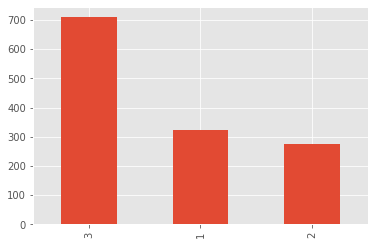

In [70]:
all_df.Pclass.value_counts()
all_df.Pclass.value_counts().plot.bar()

In [71]:
all_df[['Pclass','Fare']].groupby('Pclass').describe()

Fare                                                                 
        count       mean        std  min      25%      50%       75%       max
Pclass                                                                        
1       323.0  87.508992  80.447178  0.0  30.6958  60.0000  107.6625  512.3292
2       277.0  21.179196  13.607122  0.0  13.0000  15.0458   26.0000   73.5000
3       709.0  13.302889  11.486238  0.0   7.7500   8.0500   15.2458   69.5500

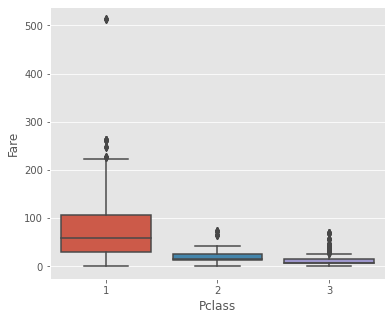

In [72]:
plt.figure(figsize=(6,5))
sns.boxplot(x='Pclass',y='Fare',data=all_df)

In [73]:
train_df=pd.read_csv('/content/drive/MyDrive/titanic_com/data/train.csv')
test_df=pd.read_csv('/content/drive/MyDrive/titanic_com/data/test.csv')
all_df=pd.concat([train_df,test_df],sort=False).reset_index(drop=True)

In [74]:
all_df['Pclass2']=all_df['Pclass']

In [75]:
all_df.loc[all_df['Fare']>108,'Pclass2']=0
all_df[all_df['Pclass2']==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass2
27,28,0.0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S,0
31,32,1.0,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,0
88,89,1.0,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S,0
118,119,0.0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,0
195,196,1.0,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,1263,NaN,1,"Wilson, Miss. Helen Alice",female,31.0,0,0,16966,134.5000,E39 E41,C,0
1266,1267,NaN,1,"Bowen, Miss. Grace Scott",female,45.0,0,0,PC 17608,262.3750,NaN,C,0
1291,1292,NaN,1,"Bonnell, Miss. Caroline",female,30.0,0,0,36928,164.8667,C7,S,0
1298,1299,NaN,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C,0


In [76]:
all_df[['Pclass2','Age']].groupby('Pclass2').describe()

Age                                                     
         count       mean        std   min   25%   50%    75%   max
Pclass2                                                            
0         76.0  35.242368  15.422162  0.92  24.0  35.0  45.50  67.0
1        208.0  40.591346  13.981486  4.00  30.0  40.5  50.25  80.0
2        261.0  29.506705  13.638627  0.67  22.0  29.0  36.00  70.0
3        501.0  24.816367  11.958202  0.17  18.0  24.0  32.00  74.0

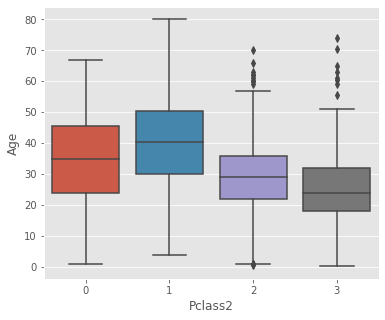

In [77]:
plt.figure(figsize=(6,5))
sns.boxplot(x='Pclass2',y='Age',data=all_df)

In [78]:
all_df[all_df['Age']>15][['Pclass2','Age']].groupby('Pclass2').describe()

Age                                                    
         count       mean        std   min   25%   50%   75%   max
Pclass2                                                           
0         69.0  37.920290  13.428357  17.0  27.0  36.0  48.0  67.0
1        207.0  40.768116  13.780416  16.0  30.0  41.0  50.5  80.0
2        233.0  32.369099  11.363367  16.0  24.0  30.0  39.0  70.0
3        422.0  28.200237   9.634512  16.0  21.0  26.0  33.0  74.0

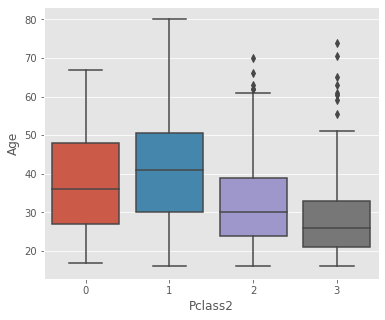

In [79]:
plt.figure(figsize=(6,5))
sns.boxplot(x='Pclass2',y='Age',data=all_df[all_df['Age']>15])

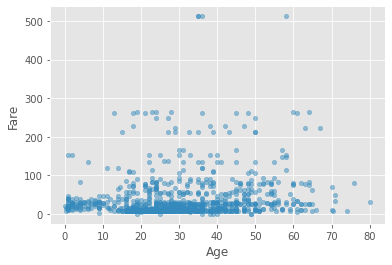

In [80]:
all_df.plot.scatter(x='Age',y='Fare',alpha=0.5)

In [81]:
all_df['familly_num']=all_df['SibSp']+all_df['Parch']

In [82]:
all_df[['Pclass2','familly_num']].groupby('Pclass2').describe()

familly_num                                              
              count      mean       std  min  25%  50%  75%   max
Pclass2                                                          
0              81.0  1.543210  1.541504  0.0  0.0  1.0  2.0   5.0
1             242.0  0.553719  0.687172  0.0  0.0  0.0  1.0   3.0
2             277.0  0.761733  1.029060  0.0  0.0  0.0  1.0   5.0
3             709.0  0.968970  1.921230  0.0  0.0  0.0  1.0  10.0

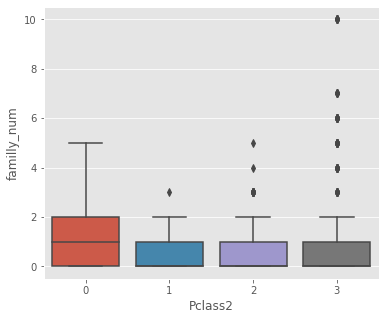

In [83]:
plt.figure(figsize=(6,5))
sns.boxplot(x='Pclass2',y='familly_num',data=all_df)

In [84]:
Pclass_gender_df=all_df[['Pclass2','Sex','PassengerId',]].dropna().groupby(['Pclass2','Sex']).count().unstack()

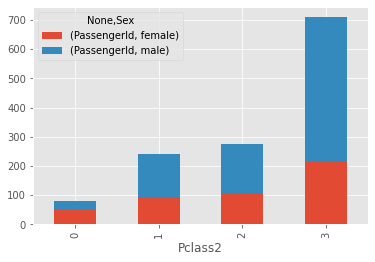

In [85]:
Pclass_gender_df.plot.bar(stacked=True)

In [86]:
Pclass_gender_df

PassengerId     
Sex          female male
Pclass2                 
0                51   30
1                93  149
2               106  171
3               216  493

In [87]:
pclass_emb_df=all_df[['Pclass2','Embarked','PassengerId']].dropna().groupby(['Pclass2','Embarked']).count().unstack()

In [88]:
pclass_emb_df=pclass_emb_df.fillna(0)

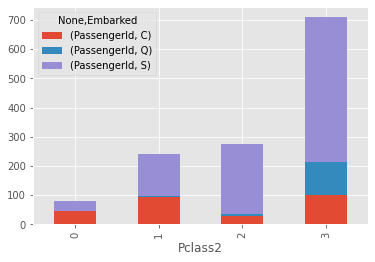

In [89]:
pclass_emb_df.plot.bar(stacked=True)

In [95]:
c_youg10=all_df[(all_df['Embarked']=='C')&(all_df['Age']//10==1)&(all_df['familly_num']==0)]

In [97]:
c_youg20=all_df[(all_df['Embarked']=='C')&(all_df['Age']//10==2)&(all_df['familly_num']==0)]

In [100]:
len(c_youg20)

31

NameError: ignored

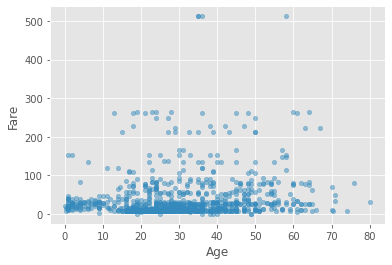

In [104]:
ax=all_df.plot.scatter(x='Age',y='Fare',alpha=0.5)
c_youg10=plot.scatter(x='Age',y='Fare',color='red',alpha=0.5,ax=ax)

NameError: ignored

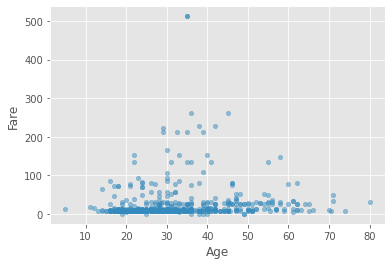

In [105]:
ax=all_df[all_df['familly_num']==0].plot.scatter(x='Age',y='Fare',alpha=0.5)
c_youg20=plot.scatter(x='Age',y='Fare',color='red',alpha=0.5,ax=ax)

NameError: ignored

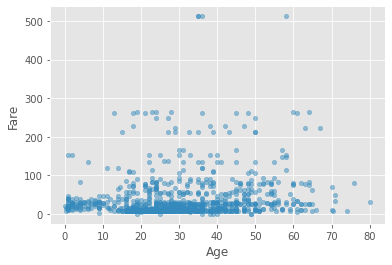

In [108]:
c_all=all_df[(all_df['Embarked']=='C')]
ax=all_df.plot.scatter(x='Age',y='Fare',alpha=0.5)
c_all=plot.scatter(x='Age',y='Fare',color="red",alpha=0.5,ax=ax)

In [112]:
all_df[(all_df['Age']//10==1)&(all_df['familly_num']==0)][['Embarked','Fare']].groupby('Embarked').mean()

,Fare
Embarked,
C,10.594057
Q,7.531944
S,16.218712
